# 2022-10-04 • Use faster curve fit for connection inference

As we saw in the previous notebook, we can get away with way fewer Levenberg-Marquardt steps (see [here](https://tfiers.github.io/phd/nb/2022-09-13__Fit_simpler_function.html#fit) for more on that algo) to get a decent fit: the difference in fit quality between 10 and the default ~350 iterations is not that big.

## Imports

In [1]:
#

In [2]:
using MyToolbox

In [3]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


The faster modelling code has been consolidated in the codebase (`src/infer/model_STA.jl`).

## Params

In [4]:
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1, g_EI = 1, g_IE = 4, g_II = 4,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Load STA's

### Load all STA's

Skip this section if you want just one.

In [5]:
out = cached_STAs(p);  # Takes 15.2 seconds

Loading cached output from `C:\Users\tfiers\.phdcache\calc_all_STAs\b9353bdd11d8b8cb.jld2` … done (59.7 s)


In [6]:
(ct, STAs, shuffled_STAs) = out;

In [8]:
α = 0.05 
conns = ct.pre .=> ct.post
example_conn(typ) = conns[findfirst(ct.conntype .== typ)]
conn = example_conn(:exc)  # 139 => 1

139 => 1

In [9]:
STA = copy(STAs[conn]);

### Load 1 STA

In [7]:
path = cachepath("2022-10-04__inspect_curve_fit", "STA");

In [8]:
# savecache(path, STA);

In [10]:
# using SnoopCompile
# tinf = @snoopi_deep loadcache(path);

In [13]:
@time STA = loadcache(path);

  0.001685 seconds (162 allocations: 20.773 KiB)


## Test one

In [10]:
fit, model = STA_modelling_funcs(p);

In [14]:
@time fit(STA, maxIter=10);  # compile

 46.001655 seconds (24.74 M allocations: 1.190 GiB, 8.58% gc time, 99.96% compilation time: 0% of which was recompilation)


In [20]:
fitfunc = fit $ (; maxIter = 10)
testfunc = modelfit_test $ (; modelling_funcs = (fitfunc, model))
test_conn(testfunc, STAs[conn], shuffled_STAs[conn])

(predtype = :exc, pval = 0.01, pval_type = "<", Eness = 0.379)

In [34]:
@time test_conn(testfunc, STAs[conn], shuffled_STAs[conn]);

  0.498189 seconds (10.52 k allocations: 19.963 MiB, 18.48% gc time)


This used to be 5.8 seconds (or even 50 seconds).

## Test sample

In [40]:
samplesize = 100
resetrng!(1234)
i = sample(1:nrow(ct), samplesize, replace = false)
ctsample = ct[i, :];

In [41]:
summarize_conns_to_test(ctsample)

We test 100 putative input connections to 45 neurons.
32 of those connections are excitatory, 15 are inhibitory, and the remaining 53 are non-connections.


In [47]:
tc = test_conns(testfunc, ctsample, STAs, shuffled_STAs, α = 0.05);

Testing connections: 100%|██████████████████████████████| Time: 0:00:33


In [46]:
perftable(tc)

Tested connections: 100,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,44,12,2,,76%
Predicted type,exc,3,20,0,,87%
└,inh,6,0,13,,68%
,,,,,,
Sensitivity,,83%,62%,87%,,


In [55]:
tc[(tc.conntype .== :exc), :]

Row,posttype,post,pre,conntype,predtype,pval,pval_type,Eness
,Symbol,Int64,Int64,Symbol,Symbol,Float64,String,Float64
1,exc,17,207,exc,exc,0.01,<,2
2,exc,35,171,exc,exc,0.01,<,2
3,exc,29,682,exc,unconn,0.11,=,0.075
4,exc,7,161,exc,exc,0.01,<,0.885
5,exc,39,178,exc,exc,0.02,=,0.284
6,exc,19,515,exc,exc,0.02,=,0.108
7,exc,36,648,exc,unconn,0.59,=,0.0565
8,inh,803,757,exc,exc,0.01,<,0.705
9,exc,39,352,exc,unconn,0.19,=,0.0613


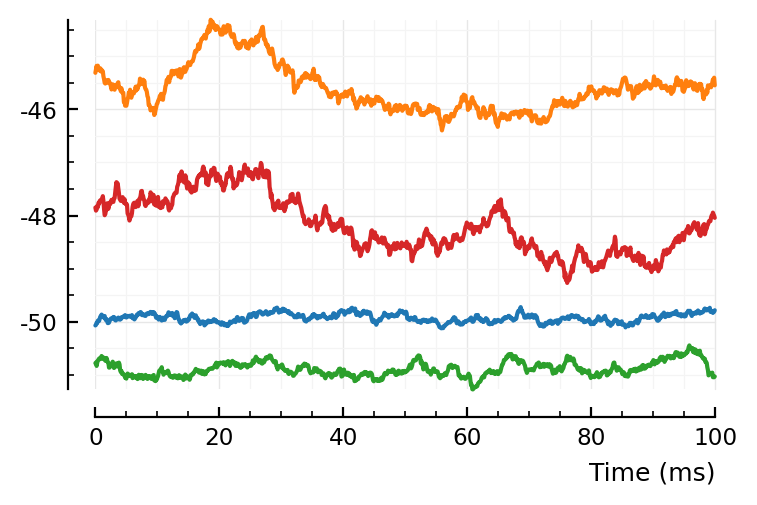

In [61]:
plotsig(STAs[20=>28] / mV, p);
plotsig(STAs[451=>6] / mV, p);
plotsig(STAs[770=>18] / mV, p);
plotsig(STAs[33=>806] / mV, p);

oh ow, is this the nonlinearity of Izhikevich at play? (Weaker excitation at lower voltages). Hm or is that sth else ([nb](https://tfiers.github.io/phd/nb/2021-12-08__biology_vs_Izh_subhtr.html)).